<a href="https://colab.research.google.com/github/williameclee/trade-cumulus-inversion/blob/main/invtci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trade Cumulus Inversion

## Loading of necessary libraries
The required libraries include: `numpy`, `scipy`, `matplotlib`, and custom libraries `inv` and `updateboundary`.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from inv import *
from updateBoundary import *

## Speficication of experiment parameters

In [2]:
# Experiment dimensions
K = 61
J = 81
Jt = 2 * J + 1
Kt = K + 2

# Physical parameters
R = 287.
cp = 1004.
kappa = R / cp
gr = 9.81
Ae = 6.371e06
Omega = 7.292e-05
rom = Ae * Omega

## Initialising paremeters for experiment 2

In [3]:
thetat = 320.  # theta (kelvin) at model top
thetab = 300.  # theta (kelvin) at model bottom
sigma0 = 45. * 100  # sigma0 (Pa/K)
pb = 1000 * 100  # pressure (Pa) at model bottom

Dp = 58. * 100  # pressure (Pa) change across inversion
theta10 = 303.  # mean theta (kelvin) in inversion
Dtheta = 4.  # dtheta (kelvin) of inversion
thetac = 3.  # thetac (kelvin) of inversion

phis = -30.  # southern extent of inversion (degrees)
phin = 30.  # northern extent of inversion (degrees)
phic = 0.  # latitude (degrees) of inversion center

pt = pb - sigma0 * (thetat - thetab) + Dp

In [4]:
alpha = (pb - pt) / pb
beta = thetab / (thetat - thetab)
cs = alpha * R * (thetat - thetab)
eps = 4 * rom**2 / cs

## Initialising coordinates

In [5]:
# Horizontal grid
Y = np.linspace(-1, 1, Jt)  # Potential latitude (S) in the paper
DY = Y[1] - Y[0]
phi = np.rad2deg(np.arcsin(Y))

# Vertical grid
Z = np.linspace(0, 1, K)
DZ = Z[1] - Z[0]
th = np.linspace(thetab, thetat, K).T
Dth = th[1] - th[0]
th_pad = np.concatenate((np.array([thetab - Dth]), th, np.array([thetat + Dth])))

YY, Th_pad = np.meshgrid(Y, th_pad, indexing="ij")
phii = np.meshgrid(phi, th_pad, indexing="ij")[0]

fac1 = eps * DY * Y
fac2 = 2 * DY * DZ**2
f1 = fac1 * (1 - Y**2)

## Initialising variables for experiment 2

In [6]:
# Theta
phi_N = (phi <= phin) & (phi > phic)
phi_S = (phi >= phis) & (phi < phic)
phi_C = phi == phic
th1 = np.full((Jt), theta10)

th1[phi_N] = theta10 + Dtheta * fexp((phin - phi[phi_N]) / (phin - phic))
th1[phi_S] = theta10 + Dtheta * fexp((phi[phi_S] - phis) / (phic - phis))
th1[phi_C] = theta10 + Dtheta
th2 = th1 + thetac

del phi_N, phi_S, phi_C

#  Pressure
th1_grid = np.meshgrid(th1, th_pad, indexing="ij")[0]
th2_grid = np.meshgrid(th2, th_pad, indexing="ij")[0]
th_T = Th_pad >= th2_grid
th_C = (Th_pad > th1_grid) & (Th_pad < th2_grid)
th_B = Th_pad <= th1_grid
Pres = pb - sigma0 * (Th_pad - thetab)
Pres[th_T] = Pres[th_T] + Dp
Pres[th_C] = Pres[th_C] + Dp * fexp((Th_pad[th_C] - th1_grid[th_C]) / thetac)
Pres = Pres / pb
pref = np.zeros([1, Kt])
for k in range(Kt):
    pref[0, k] = pmean(Pres[:, k], Y)
Gamma = Pres ** (kappa - 1)

In [7]:
# compute initial m field at even points
# the M (Montgomery potential) is normalised by a factor of cs
X = np.zeros((Jt, Kt))

X[1:-1:2, 1] = cp * thetab / cs
for j in range(1, Jt - 1, 2):
    Mp = Pres[j, 1:-1] ** kappa / (kappa * alpha)
    X[j, 1:-1] = intdde(Mp, X[j, 1], DZ)
X[1:-1:2, 0] = X[1:-1:2, 2] - 2 * DZ * X[1:-1:2, 1] / beta
X[1:-1:2, -1] = X[1:-1:2, -3] + 2 * DZ * (1 - alpha) ** kappa / (kappa * alpha)

# initialise x (i.e., sin(phi)) at odd points
X[::2, :] = np.tile(Y[::2], (Kt, 1)).T

## Compute Sigma

In [8]:
tinc = 0.1
Sigma = np.ones((Jt, Kt)) 

# Calculate sigma values
for j in range(Jt):
    for k in range(1,Kt):
        if th_C[j, k] != 1:
            continue
        tp = th[k] + tinc
        tm = th[k] - tinc
        fp = (tp - th1[j]) / (th2[j] - th1[j])
        fm = (tm - th1[j]) / (th2[j] - th1[j])
        dfdt = (fp - fm) / (2 * tinc)
        Sigma[j, k] = (sigma0 - Dp * dfdt) / sigma0

del th1_grid, th2_grid, th_T, th_C

In [9]:
X, Pres, Gamma, pmean = updateBoundary(X, Y, DZ, Pres, Gamma, pref, fac1, alpha, beta, eps, kappa)

Pres0 = Pres.copy()
X0 = X.copy()

/Users/williewillow/Documents/COLLEGE/2023Summer/trade-cumulus-inversion/updateBoundary.py:19: RuntimeWarning: invalid value encountered in divide
  t = (Y[::2] ** 2 - X[::2, 1] ** 2) / (1 - X[::2, 1] ** 2)


## Iteration

In [10]:
for n in range(800):
    for kz in [1, 2]:
        for niter in range(4):
            for k in range(kz, Kt - 1, 2):
                Jac = np.zeros([X.shape[0], X.shape[0]])
                G = np.zeros((X.shape[0], 1))

                for j in range(1, Jt - 1, 2):
                    dsdY = X[j + 1, k] - X[j - 1, k]
                    dMdZZ = X[j, k - 1] - 2 * X[j, k] + X[j, k + 1]

                    Jac[j, j] = -2 * dsdY
                    Jac[j, j - 1] = -dMdZZ
                    Jac[j, j + 1] = dMdZZ
                    G[j] = dsdY * dMdZZ + Gamma[j, k] * Sigma[j, k] * fac2

                for j in range(2, Jt - 2, 2):
                    dMdY = X[j + 1, k] - X[j - 1, k]

                    Jac[j, j] = (
                        fac1[j]
                        * (2 * X[j, k])
                        * (1 - Y[j] ** 2)
                        / (1 - X[j, k] ** 2) ** 2
                    )
                    Jac[j, j - 1] = -1
                    Jac[j, j + 1] = 1
                    G[j] = dMdY - fac1[j] * (Y[j] ** 2 - X[j, k] ** 2) / (
                        1 - X[j, k] ** 2
                    )

                X[1:-1, k] = X[1:-1, k] - np.linalg.solve(Jac[1:-1, 1:-1], G[1:-1]).T
    X, Pres, Gamma, pmean = updateBoundary(
        X, Y, DZ, Pres, Gamma, pref, fac1, alpha, beta, eps, kappa
    )

## Plot Pre- and Post-Adjusted Fields

In [11]:
## Interpolate variables back to physical space
M_int = np.arange(1, Jt, 2)
s_int = np.arange(2, Jt - 1, 2)

s_intp = X
s_intp[M_int, :] = (X[M_int + 1, :] + X[M_int - 1, :]) / 2
M_intp = X
M_intp[s_int, :] = (X[s_int + 1, :] + X[s_int - 1, :]) / 2
Pres_intp = Pres * pb / 100
Pres_intp[s_int, :] = (Pres_intp[s_int + 1, :] + Pres_intp[s_int - 1, :]) / 2
Pres0_intp = Pres0 * pb / 100
Pres0_intp[s_int, :] = (Pres0_intp[s_int + 1, :] + Pres0_intp[s_int - 1, :]) / 2

phi_intp = np.rad2deg(np.arcsin(s_intp))
Phi_intp = np.rad2deg(np.arcsin(YY))

u = (
    Omega
    * Ae
    * (np.sin(np.deg2rad(phi_intp)) ** 2 - np.sin(np.deg2rad(Phi_intp)) ** 2)
    / np.cos(np.deg2rad(phi_intp))
)
u[M_int, :] = (u[M_int + 1, :] + u[M_int - 1, :]) / 2

T = Th_pad * (Pres_intp / (pb / 100)) ** kappa
T0 = Th_pad * (Pres0_intp / (pb / 100)) ** kappa
DTDH = np.zeros((Jt, Kt))
DTDH0 = np.zeros((Jt, Kt))
DTDH[:, 2:-2] = (
    (T[:, 3:-1] - T[:, 1:-3])
    / (R * T[:, 2:-2] / gr * np.log(Pres_intp[:, 1:-3] / Pres_intp[:, 3:-1]))
    * 1000
)
DTDH0[:, 2:-2] = (
    (T0[:, 3:-1] - T0[:, 1:-3])
    / (R * T0[:, 2:-2] / gr * np.log(Pres0_intp[:, 1:-3] / Pres0_intp[:, 3:-1]))
    * 1000
)

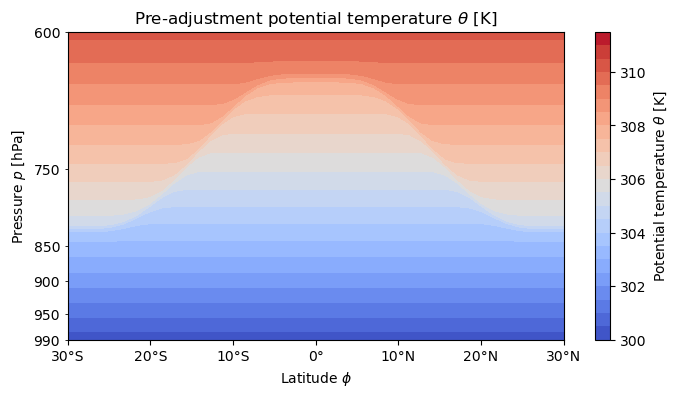

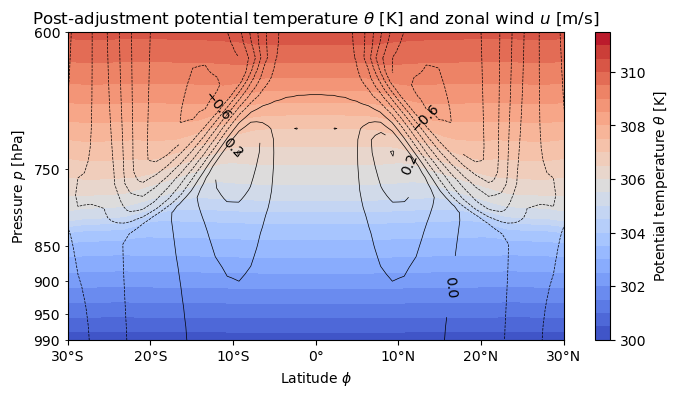

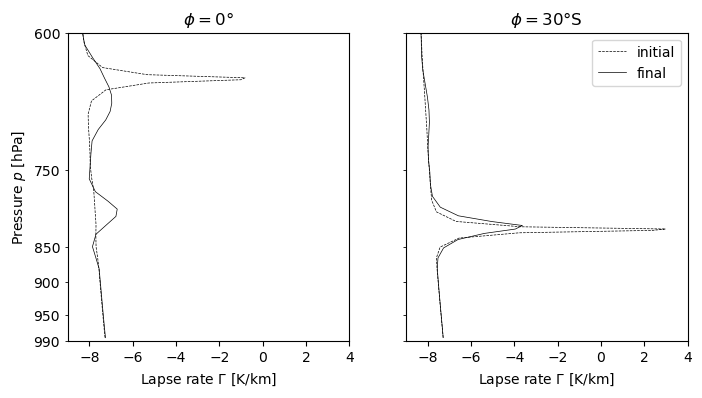

In [12]:
import matplotlib.ticker as mticker

## Plot
lat_xlim = [-30, 30]
lat_xticks = np.arange(-30, 40, 10)
lat_xticklabels = ['30°S','20°S','10°S','0°','10°N','20°N','30°N']
lat_xlabel = r"Latitude $\phi$"
gamma_xlim = [-9, 4]
gamma_xticks = np.arange(-8, 5, 2)
gamma_xlabel = r"Lapse rate $\Gamma$ [K/km]"
ylim = [990, 600]
yticks = [ylim[1], 750, 850, 900, 950, ylim[0]]
ylabel = r"Pressure $p$ [hPa]"
cticks = np.arange(300, 312, 2)

# Initial fields
fig, ax = plt.subplots(figsize=(8, 4))
plt_theta_i_conf = ax.contourf(
    phi_intp, Pres0_intp, Th_pad, levels=np.arange(300, 312, 0.5), cmap="coolwarm"
)

cbar = fig.colorbar(plt_theta_i_conf)
cbar.set_ticks(cticks)
cbar.set_label(r"Potential temperature $\theta$ [K]")
ax.set_yscale("log")
ax.set_xlim(lat_xlim)
ax.set_ylim(ylim)
ax.set_xticks(lat_xticks, lat_xticklabels)
ax.set_yticks(yticks, minor=True)
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set_xlabel(lat_xlabel)
ax.set_ylabel(ylabel)
ax.set_title(r"Pre-adjustment potential temperature $\theta$ [K]")
plt.savefig("./Figures/exp2_theta_i.png", dpi=300)
plt.show()

# Final fields
fig, ax = plt.subplots(figsize=(8, 4))
plt_theta_f_conf = ax.contourf(
    phi_intp, Pres_intp, Th_pad, levels=np.arange(300, 312, 0.5), cmap="coolwarm"
)
plt_theta_f_cont = ax.contour(
    phi_intp,
    Pres_intp,
    u,
    levels=np.arange(-1, 1, 0.1),
    colors="k",
    linewidths=0.5,
)
ax.clabel(plt_theta_f_cont, levels=np.arange(-1, 1, 0.2), inline=1, fontsize=10)

cbar = fig.colorbar(plt_theta_f_conf)
cbar.set_ticks(cticks)
cbar.set_label(r"Potential temperature $\theta$ [K]")
ax.set_yscale("log")
ax.set_xlim(lat_xlim)
ax.set_ylim(ylim)
ax.set_xticks(lat_xticks, lat_xticklabels)
ax.set_yticks(yticks, minor=True)
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set_xlabel(lat_xlabel)
ax.set_ylabel(ylabel)
ax.set_title(
    r"Post-adjustment potential temperature $\theta$ [K] and zonal wind $u$ [m/s]"
)
plt.savefig("./Figures/exp2_theta_f.png", dpi=300)
plt.show()

# Lapse rates
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax[0].plot(
    DTDH0[81, 2:-2],
    Pres0_intp[81, 2:-2],
    color="k",
    linewidth=0.5,
    linestyle="--",
    label="initial",
)
ax[0].plot(DTDH[81, 2:-2], Pres_intp[81, 2:-2], color="k", linewidth=0.5, label="final")

ax[0].set_yscale("log")
ax[0].set_xlim(gamma_xlim)
ax[0].set_ylim(ylim)
ax[0].set_xticks(gamma_xticks)
ax[0].set_yticks(yticks, minor=True)
ax[0].yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax[0].set_xlabel(gamma_xlabel)
ax[0].set_ylabel(ylabel)
ax[0].set_title(r"$\phi = 0°$")

ax[1].plot(
    DTDH0[40, 2:-2],
    Pres0_intp[40, 2:-2],
    color="k",
    linewidth=0.5,
    linestyle="--",
    label="initial",
)
ax[1].plot(DTDH[40, 2:-2], Pres_intp[40, 2:-2], color="k", linewidth=0.5, label="final")

ax[1].legend()
ax[1].set_xlim(gamma_xlim)
ax[1].set_xticks(gamma_xticks)
ax[1].set_xlabel(gamma_xlabel)
ax[1].set_title(r"$\phi = 30$°S")

plt.savefig("./Figures/exp2_gamma.png", dpi=300)
plt.show()